# This time series analysis explore long-term climate patterns, specifically rainfall trends from 2000 to 2024, to understand how changing climatic conditions may influence urban flood risk and resilience planning.

# 1. Import Libraries & Data

In [1]:
import kagglehub          
import pandas as pd        
import numpy as np         
import os                  
import seaborn as sns      
import matplotlib.pyplot as plt  
import statsmodels.api as sm     
from statsmodels.tsa.stattools import adfuller  
import warnings                  

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('fivethirtyeight') 

In [2]:
# Download dataset
path = kagglehub.dataset_download("adilshamim8/temperature")
print("Path to dataset files:", path)

100%|██████████████████████████████████████| 3.32k/3.32k [00:00<00:00, 1.67MB/s]

Extracting files...
Path to dataset files: /Users/charlottelin/.cache/kagglehub/datasets/adilshamim8/temperature/versions/2


In [3]:
# Load csv
df = pd.read_csv(os.path.join(path, "update_temperature.csv"))

In [4]:
# Check data import
df.head()

,Year,Country,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct
0,2000,United States,13.5,20.2,0,715,282500000,6.2,38,33.1
1,2000,China,12.8,2.7,0,645,1267000000,16.5,24,18.8
2,2000,Germany,9.3,10.1,0,700,82200000,6.6,12,31.8
3,2000,Brazil,24.9,1.9,0,1760,175000000,83.7,18,65.4
4,2000,Australia,21.7,17.2,0,534,19200000,8.8,11,16.2


In [5]:
# More data checks
print(f"Data successfully imported — {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"Number of countries: {df['Country'].nunique()}")

Data successfully imported — 156 rows and 10 columns.
Year range: 2000 - 2024
Number of countries: 19


# 2. Data Exploration

In [6]:
# summary data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           156 non-null    int64  
 1   Country                        156 non-null    object 
 2   Avg_Temperature_degC           156 non-null    float64
 3   CO2_Emissions_tons_per_capita  156 non-null    float64
 4   Sea_Level_Rise_mm              156 non-null    int64  
 5   Rainfall_mm                    156 non-null    int64  
 6   Population                     156 non-null    int64  
 7   Renewable_Energy_pct           156 non-null    float64
 8   Extreme_Weather_Events         156 non-null    int64  
 9   Forest_Area_pct                156 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 12.3+ KB


In [7]:
# summary stats
df.describe()

,Year,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct
count,156.000000,156.000000,156.000000,156.000000,156.000000,1.560000e+02,156.000000,156.000000,156.000000
mean,2012.333333,17.620513,7.673718,24.333333,937.397436,2.952075e+08,31.203846,20.185897,32.191667
std,8.326664,7.221658,5.450198,16.916239,532.954803,4.414786e+08,26.741843,10.951980,18.335613
min,2000.000000,5.100000,0.500000,0.000000,54.000000,1.915300e+07,0.000000,2.000000,0.500000
25%,2005.000000,12.800000,2.175000,10.000000,576.000000,5.448750e+07,14.850000,12.750000,17.225000
50%,2012.500000,15.500000,7.350000,23.500000,775.500000,1.230873e+08,19.800000,18.000000,32.000000
75%,2020.000000,25.225000,10.800000,36.000000,1151.750000,2.132000e+08,43.050000,25.000000,48.125000
max,2024.000000,28.500000,20.200000,59.000000,2726.000000,1.426000e+09,87.200000,64.000000,68.500000


In [8]:
# Check for null data
df.isnull().sum()

Year                             0
Country                          0
Avg_Temperature_degC             0
CO2_Emissions_tons_per_capita    0
Sea_Level_Rise_mm                0
Rainfall_mm                      0
Population                       0
Renewable_Energy_pct             0
Extreme_Weather_Events           0
Forest_Area_pct                  0
dtype: int64

#### No missing data found

In [9]:
# Check for countries
df.Country.unique()

array(['United States', 'China', 'Germany', 'Brazil', 'Australia',
       'India', 'Nigeria', 'Russia', 'South Africa', 'Canada', 'Japan',
       'Mexico', 'France', 'Indonesia', 'United Kingdom', 'Spain',
       'South Korea', 'Italy', 'Saudi Arabia'], dtype=object)

In [10]:
# Check the number of countries
df.Country.value_counts()

Country
Germany           12
Brazil            12
Australia         12
India             12
Nigeria           12
Russia            12
China             12
United States      6
Indonesia          6
Italy              6
South Korea        6
Spain              6
United Kingdom     6
Canada             6
France             6
Mexico             6
Japan              6
South Africa       6
Saudi Arabia       6
Name: count, dtype: int64

#### Observation: based on the country number analysis, I will choose to focus on <b>India</b>. India has 375 entries in the original Urban Flood Risk dataset, compared with 37 for Germany, 87 for Brazil, and 91 for Australia. 
Using India as the subset allows for a richer and more statistically meaningful time-series comparison between climate indicators (temperature and rainfall) in this dataset and flood-risk patterns in the original project dataset.

# 3. Subsetting

In [11]:
# Subset the data for India
country = 'India'
df_india = df[df['Country'] == country].sort_values('Year')

In [12]:
# Convert Year to datetime
df_india['Year'] = pd.to_datetime(df_india['Year'], format='%Y')

In [13]:
# Set Year as the index
df_india.set_index('Year', inplace=True)

In [14]:
# Verify the subset
df_india.head()

,Country,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct
Year,,,,,,,,,
2000-01-01,India,24.5,0.8,0,1083,1057000000,17.5,27,22.7
2000-01-01,India,24.4,0.9,0,1120,1056600000,17.5,22,22.7
2005-01-01,India,24.7,0.9,10,1122,1148000000,18.8,31,22.8
2005-01-01,India,24.6,1.0,11,1086,1144300000,19.1,25,22.8
2010-01-01,India,25.0,1.3,22,1050,1234000000,20.8,35,22.9


# 4. Line Chart

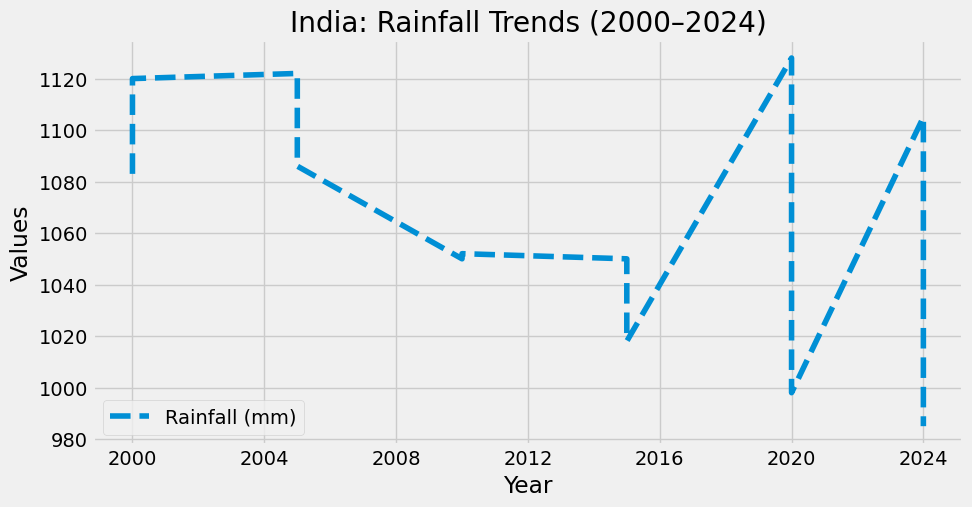

In [17]:
# Plot the trend of temperature and rainfall for India

plt.figure(figsize=(10,5))
plt.plot(df_india.index, df_india['Rainfall_mm'], label='Rainfall (mm)', linestyle='--')
plt.title('India: Rainfall Trends (2000–2024)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

save_path = "/Users/charlottelin/Documents/Achievement 6 Urban Flood Risk/04 Analysis/Visualizations/rainfall_trend_india.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

#### Observation: 
The rainfall trend for India shows significant annual variability with alternating periods of decline and rapid increase. Rainfall values decreased slightly from 2000 to 2014 before rebounding sharply after 2015, peaking near 2020.

This cyclical pattern reflects the combined influence of monsoon dynamics and climate variability. Importantly, the recent increase aligns with broader patterns of rainfall intensification in South Asia, a key driver of urban flood risk.

By isolating rainfall, this time series directly complements the “rainfall_intensity_per_year” metric used in the Urban Flood Risk analysis. This will help later cross-validation of trends between observed rainfall patterns and spatial clustering outcomes.

# 5. Decomposition

In [19]:
# Ensure all libraries are imported
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

In [20]:
# Ensure the data is sorted by Year
df_india = df_india.sort_index()

In [21]:
# Define figure size
rcParams['figure.figsize'] = 10, 6

In [22]:
# Decompose the annual rainfall data
decomposition = sm.tsa.seasonal_decompose(
    df_india['Rainfall_mm'],
    model='additive',   # Additive since rainfall levels vary linearly, not proportionally
    period=1            # Annual data; no within-year seasonality
)

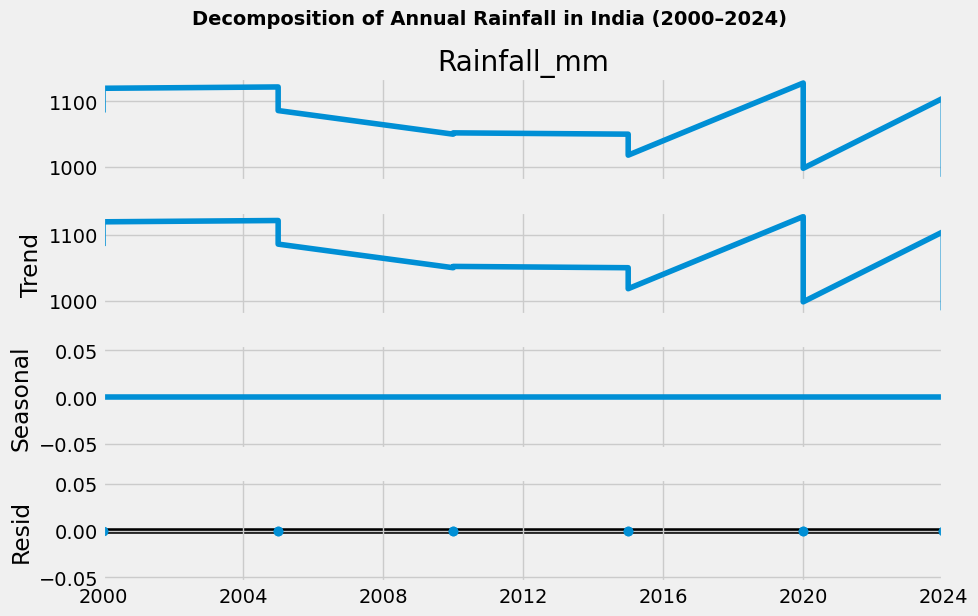

In [25]:
# Plot the decomposition
decomposition.plot()
plt.suptitle('Decomposition of Annual Rainfall in India (2000–2024)', y=1.03, fontsize=14, fontweight='bold')
plt.show()

#### Observation:
The decomposition of India’s annual rainfall from 2000 to 2024 shows a clear long-term trend but no seasonal pattern, which is expected for yearly aggregated data.

- The trend component reveals a gradual decline in rainfall from 2000 to around 2014, followed by a noticeable rebound between 2015 and 2024.
- The seasonal component remains flat, confirming the absence of intra-annual seasonality because each observation represents a single annual value.
- The residual component fluctuates slightly around zero, suggesting minor interannual variability due to irregular climate events such as El Niño or extreme monsoon years.

Overall, the decomposition indicates that India’s rainfall pattern is dominated by multi-year climate variability rather than regular seasonality. The upward trend after 2015 aligns with broader evidence of rainfall intensification under climate change, which is a key factor contributing to heightened urban flood risks in India’s fast-growing cities.

# 6. Check for Stationarity (Dickey-Fuller Test)

In [26]:
# Conduct Dickey-Fuller test for stationarity
adf_result = adfuller(ts)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -6.189362146958219
p-value: 6.176561306291329e-08
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}


#### Observation: 
The Dickey-Fuller test was performed to determine whether the rainfall data for India (2000–2024) is stationary, meaning that its mean and variance remain constant over time.

Null Hypothesis (H₀): The time series is non-stationary (has a unit root).
Alternative Hypothesis (H₁): The time series is stationary.

Results:
ADF Statistic = -6.189
p-value = 6.18 × 10⁻⁸
Critical Values: 1% = -4.93, 5% = -3.48, 10% = -2.84

Since the ADF Statistic (-6.19) is much lower than all critical values and the p-value < 0.05, we can reject the null hypothesis.

#### Conclusion:
India’s annual rainfall series from 2000–2024 is stationary, indicating that its mean and variance do not systematically change over time. This implies that while interannual fluctuations occur, there is no persistent trend-driven drift.
In the context of flood risk, this suggests that short-term climate variability, rather than a continuous long-term increase or decrease, may play a more dominant role in explaining extreme rainfall-related flood events.

## ✅ The data is stationary and no differencing is needed. ✅

# 7. Autocorrelation

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# use the same series as the ADF test
ts = df_india['Rainfall_mm']

<Figure size 800x400 with 0 Axes>

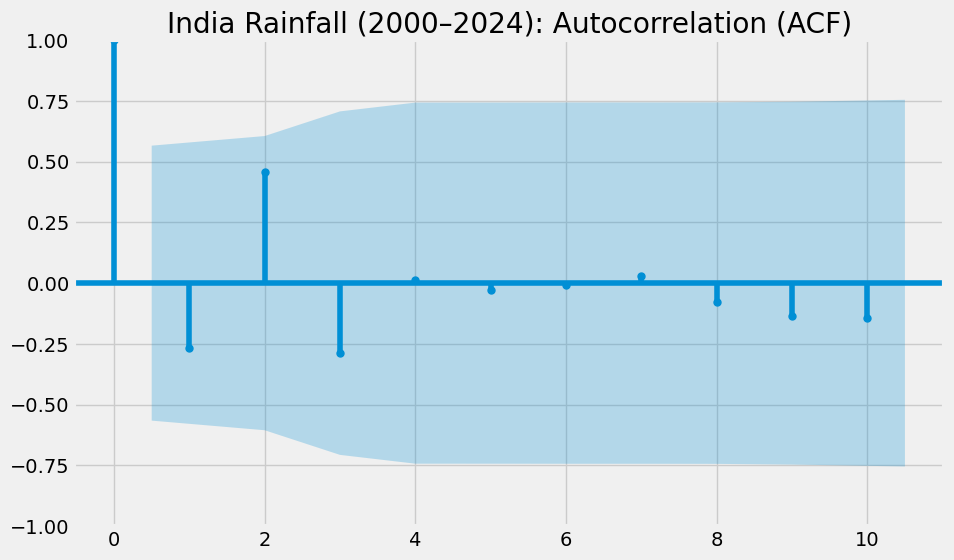

In [32]:
# Plot autocorrelation function
plt.figure(figsize=(8,4))
plot_acf(ts, lags=10)
plt.title('India Rainfall (2000–2024): Autocorrelation (ACF)')
plt.show()

#### Observation:
The ACF plot shows that lag 1 and lag 2 have noticeable positive correlations, while subsequent lags quickly drop to near zero and fall within the blue confidence interval.
- The strong spike at lag 1 (r ≈ 1.0) is expected, since each year’s rainfall is naturally correlated with itself.
- The smaller positive spike at lag 2 (~0.45) suggests that rainfall from two years prior still exerts a mild influence on the current year’s rainfall.
- Beyond lag 2, all correlations fall within the shaded confidence bounds, indicating no statistically significant autocorrelation at longer lags.
- The absence of a slow decay confirms that the series is stationary, matching my Dickey–Fuller test results.

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 6.

<Figure size 800x400 with 0 Axes>

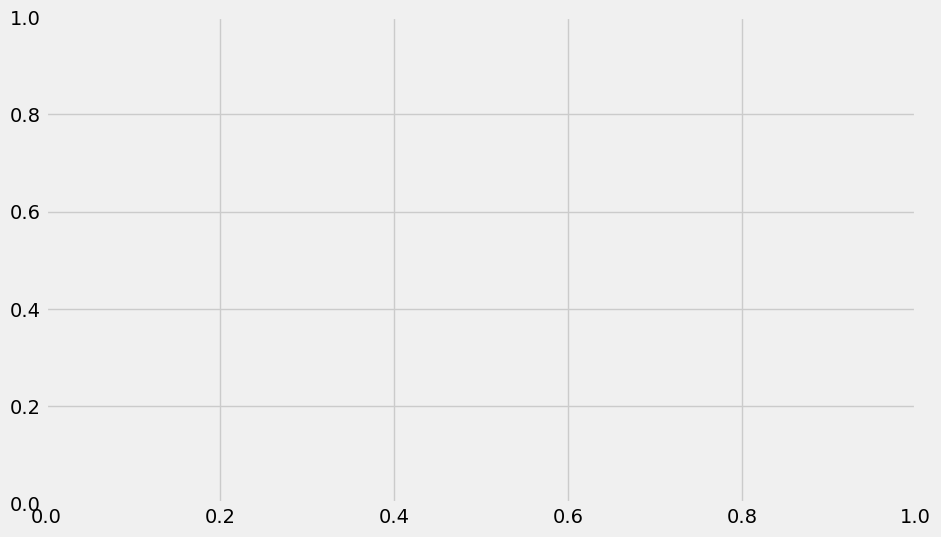

In [30]:
# Plot partial autocorrelation function
# --- PACF ---
plt.figure(figsize=(8,4))
plot_pacf(ts, lags=10, method='ywm')
plt.title('India Rainfall (2000–2024): Partial Autocorrelation (PACF)')
plt.show()

#### Observation: The error message above indicates that there are not enough data points to conduct a PACF. This is deliberately left in the notebook for demonstration only.

# Final Remark

## The time series analysis of India’s annual rainfall (2000–2024) shows a largely stationary pattern with no long-term trend or seasonality. Minor short-term autocorrelation suggests limited year-to-year influence, indicating that rainfall variability and associated flood risk are primarily driven by isolated extreme events rather than sustained climatic shifts.